## Relax Data Science Challenge

1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:<br>
● name: the user's name\
● object_id: the user's id\
● email: email address\
● creation_source: how their account was created. This takes on one of 5 values:

○ PERSONAL_PROJECTS: invited to join another user's personal workspace\
○ GUEST_INVITE: invited to an organization as a guest (limited permissions)\
○ ORG_INVITE: invited to an organization (as a full member)\
○ SIGNUP: signed up via the website\
○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

● creation_time: when they created their account\
● last_session_creation_time: unix timestamp of last login\
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails\
● enabled_for_marketing_drip: whether they are on the regular marketing email drip\
● org_id: the organization (group of users) they belong to\
● invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday
period , identify which factors predict future user adoption.

### Set Environment and Read Data

In [1]:
# set up environment

import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import datetime
import matplotlib.dates as mdates

In [2]:
# load first file, "takehome_users.csv"

df_cust = pd.read_csv("takehome_users.csv", encoding = 'unicode_escape', engine ='python')
df_cust.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# load second file, "takehome_user_engagement.csv"

df_visit = pd.read_csv("takehome_user_engagement.csv")
df_visit.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### EDA / Study Datasets

In [4]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
df_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
print("Number of registered users :", df_cust['object_id'].nunique())
print("Number of users who logged in :", df_visit['user_id'].nunique())

Number of registered users : 12000
Number of users who logged in : 8823


In [7]:
# convert unix timestamp to datetime format

df_cust['last_session_time'] = pd.to_datetime(df_cust['last_session_creation_time'], unit='s')
df_cust.drop('last_session_creation_time', axis = 1, inplace = True)

In [8]:
# identify adopted users

curr_uid = 0
adopted_users = []
for i in range(len(df_visit)-2):
    uid = df_visit['user_id'][i] 
    if uid != curr_uid and uid == df_visit['user_id'][i+2]:
        st = pd.Timestamp(df_visit['time_stamp'][i])
        et = st + pd.Timedelta('7D') 
        if st < pd.Timestamp(df_visit['time_stamp'][i+1]) < et and st < pd.Timestamp(df_visit['time_stamp'][i+2]) < et:
            adopted_users.append(uid) 
            curr_uid = uid 
            

In [9]:
print("Number of adopted users :",len(adopted_users))

Number of adopted users : 1602


In [10]:
# added 'active' flag to indicate adopted users
# True - adopted user
# False - active user (who has logged in at some point)

df_visit['active'] = np.where(df_visit['user_id'].isin(adopted_users), True, False)
df_visit

,time_stamp,user_id,visited,active
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,True
2,2013-11-29 03:45:04,2,1,True
3,2013-12-09 03:45:04,2,1,True
4,2013-12-25 03:45:04,2,1,True
...,...,...,...,...
207912,2013-09-06 06:14:15,11996,1,False
207913,2013-01-15 18:28:37,11997,1,False
207914,2014-04-27 12:45:16,11998,1,False
207915,2012-06-02 11:55:59,11999,1,False


In [29]:
df_visit_unique = df_visit.groupby(['user_id', 'active']).agg({'time_stamp' : 'min', 'visited':'count'})
#df_visit_unique = df_visit.groupby(['user_id', 'active']).agg({'visited':'count'})
df_visit_u = df_visit_unique.reset_index()
df_visit_u

,user_id,active,time_stamp,visited
0,1,False,2014-04-22 03:53:30,1
1,2,True,2013-11-15 03:45:04,14
2,3,False,2013-03-19 23:14:52,1
3,4,False,2013-05-22 08:09:28,1
4,5,False,2013-01-22 10:14:20,1
...,...,...,...,...
8818,11996,False,2013-09-06 06:14:15,1
8819,11997,False,2013-01-15 18:28:37,1
8820,11998,False,2014-04-27 12:45:16,1
8821,11999,False,2012-06-02 11:55:59,1


In [30]:
# df_visit_u['user_id'].nunique()

In [31]:
# MERGE table df_cust(customer info) and df_visit(login info)

df_merged = pd.merge(df_cust, df_visit_u, how='left', left_on=['object_id'], right_on=['user_id']) 
df_merged.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'last_session_time', 'user_id', 'active',
       'time_stamp', 'visited'],
      dtype='object')

In [32]:
# dropping a few unnecessary columns and changing data types for analysis

df = df_merged.drop('time_stamp', axis = 1)
df['creation_time'] = pd.to_datetime(df['creation_time'])
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_time,user_id,active,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22 03:53:30,1.0,False,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2014-03-31 03:45:04,2.0,True,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19 23:14:52,3.0,False,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-22 08:09:28,4.0,False,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-22 10:14:20,5.0,False,1.0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   last_session_time           8823 non-null   datetime64[ns]
 10  user_id                     8823 non-null   float64       
 11  active                      8823 non-null   object    

### Visualization of Findings 

In [37]:
# revising 'active' into a categorical column
#    active : user who logged in at some point
#    adopted : adopted user
#    non-active : registered but never logged in 

df['active'].replace(True, "adopted", inplace = True)
df['active'].replace(False, "active", inplace = True)
df['active'].fillna('non-active', inplace = True)
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_time,user_id,active,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22 03:53:30,1.0,active,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2014-03-31 03:45:04,2.0,adopted,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19 23:14:52,3.0,active,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-22 08:09:28,4.0,active,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-22 10:14:20,5.0,active,1.0


In [38]:
# breakdown of user status

df_user = df.groupby(['active'])['object_id'].count()
df_user

active
active        7221
adopted       1602
non-active    3177
Name: object_id, dtype: int64

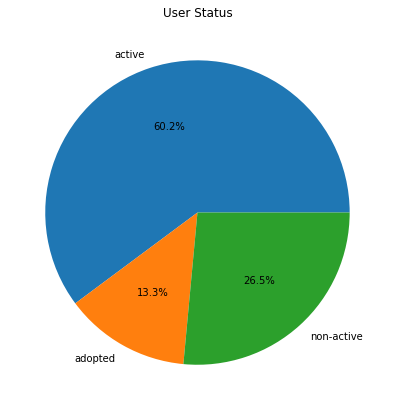

In [39]:
# pie chart of the user status

plt.ylabel
#_ = df_user.groupby(['active']).count().plot(kind='pie', y='active', figsize=(7,7), autopct='%1.1f%%', ylabel='', title = 'User Status')

_ = df_user.plot(kind='pie', y='active', figsize=(7,7), autopct='%1.1f%%', ylabel='', title = 'User Status')


**Among all registered users:**\
   **13%** - adopted users\
   **60%** - users who logged on at leaset once\
   **26%** - registered but never logged on

In [79]:
df_adopted = df[df['active']== 'adopted']
df_active = df[df['active']== 'active']
df_nonactive = df[df['active']== 'non-active']

df_source_ad = df_adopted['creation_source'].value_counts()
df_invited_ad = df_adopted['invited_by_user_id'].value_counts()
df_source_ac = df_adopted['creation_source'].value_counts()
df_source_na = df_nonactive['creation_source'].value_counts()

Text(0.5, 1.0, 'Non-Active Users')

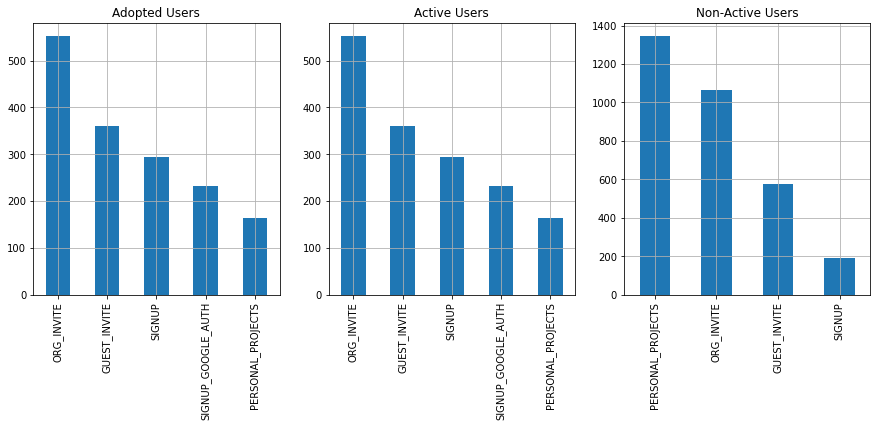

In [78]:
# plotting exploration of "creation_source" for each user status

fig, (ax1, ax2, ax3) =  plt.subplots(1, 3, sharex=False, sharey= False, figsize=(15,5)) 

df_source_ad.plot(kind='bar', grid=True, ax = ax1)
ax1.set_title('Adopted Users')
df_source_ac.plot(kind='bar', grid=True, ax = ax2)
ax2.set_title('Active Users')
df_source_na.plot(kind='bar', grid=True, ax = ax3)
ax3.set_title('Non-Active Users')


'Creation Source'\
○ PERSONAL_PROJECTS: invited to join another user's personal workspace\
○ GUEST_INVITE: invited to an organization as a guest (limited permissions)\
○ ORG_INVITE: invited to an organization (as a full member)\
○ SIGNUP: signed up via the website\
○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

Users who are invited to an organization as a full member are the highest among the Adopted and Active users.
For the Non-active users, those who are invited to join another user's personal workspace has the highest number of users. Interestingly, none of the users who signed up using Google Authentication are Non-active users.
Overall, I think it is safe to say that invitation by the organization has strong effect on the users.

In [102]:
# prep data for time series analysis

df_pivot = pd.DataFrame(df.groupby(['creation_time', 'active'])['object_id'].agg('count'))
df_pivot.reset_index(inplace=True)
df_pivot.set_index('creation_time', inplace = True)
df_pivot1 = pd.get_dummies(df_pivot)
df_pivot1.head()

,object_id,active_active,active_adopted,active_non-active
creation_time,,,,
2012-05-31 00:43:27,1,1,0,0
2012-05-31 01:42:31,1,1,0,0
2012-05-31 06:23:51,1,1,0,0
2012-05-31 08:20:06,1,1,0,0
2012-05-31 11:55:59,1,1,0,0


In [103]:
# resample into monthly data

df_pmonth = df_pivot1.resample('M').agg({"active_active": 'sum',"active_adopted": 'sum', "active_non-active": 'sum'})
df_pmonth_rev = df_pmonth.rename(columns = {"active_active": 'active',"active_adopted": 'adopted', "active_non-active": 'non-active'})
df_pmonth_rev.head()

,active,adopted,non-active
creation_time,,,
2012-05-31,12.0,1,3.0
2012-06-30,216.0,71,114.0
2012-07-31,224.0,58,105.0
2012-08-31,202.0,67,96.0
2012-09-30,212.0,67,129.0


In [104]:
# change 'creation_time' into "yyyy-mm" format

df_pmonth_rev.reset_index(inplace = True)
df_pmonth_rev['creation_time'] = pd.to_datetime(df_pmonth_rev['creation_time'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')

df_pmonth_rev.set_index('creation_time', inplace = True)
df_pmonth_rev.head()

,active,adopted,non-active
creation_time,,,
2012-05,12.0,1,3.0
2012-06,216.0,71,114.0
2012-07,224.0,58,105.0
2012-08,202.0,67,96.0
2012-09,212.0,67,129.0


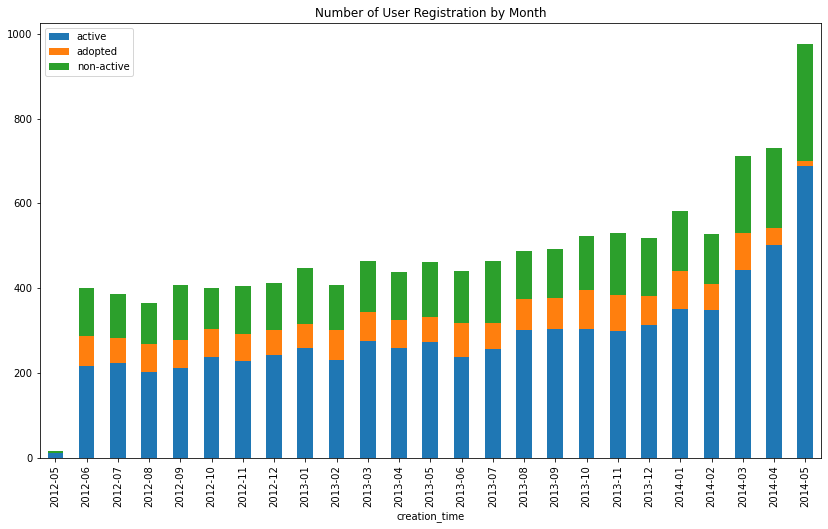

In [105]:
# plot monthly registration 

_ = df_pmonth_rev.plot(kind='bar', stacked=True, figsize = (14, 8), title = 'Number of User Registration by Month')


There is steady increase in the number of users registered each month.  However, I did not see any trend in the ratio of adopted, active and non-active users or the correlation of registration date with the current user status.

In [86]:
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_time,user_id,active,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22 03:53:30,1.0,active,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2014-03-31 03:45:04,2.0,adopted,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19 23:14:52,3.0,active,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013-05-22 08:09:28,4.0,active,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013-01-22 10:14:20,5.0,active,1.0


In [88]:
df_adopted['enabled_for_marketing_drip'].value_counts()

0    1356
1     246
Name: enabled_for_marketing_drip, dtype: int64

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   last_session_time           8823 non-null   datetime64[ns]
 10  user_id                     8823 non-null   float64       
 11  active                      12000 non-null  object    

### Feature Importance Analysis 

In [93]:
# feature engineering 

prep_data = df.drop(['creation_time', 'name', 'email', 'last_session_time', 'user_id', 'org_id', 'visited'], axis = 1)
prep_data['invited'] = np.where(prep_data['invited_by_user_id'].isna(), 0, 1)
prep_data.drop(['object_id', 'invited_by_user_id'], axis = 1, inplace=True)

In [94]:
prep_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,active,invited
0,GUEST_INVITE,1,0,active,1
1,ORG_INVITE,0,0,adopted,1
2,ORG_INVITE,0,0,active,1
3,GUEST_INVITE,0,0,active,1
4,GUEST_INVITE,0,0,active,1


In [106]:
data = pd.get_dummies(prep_data, columns = ['creation_source'])
data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,active,invited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,active,1,1,0,0,0,0
1,0,0,adopted,1,0,1,0,0,0
2,0,0,active,1,0,1,0,0,0
3,0,0,active,1,1,0,0,0,0
4,0,0,active,1,1,0,0,0,0


<AxesSubplot:>

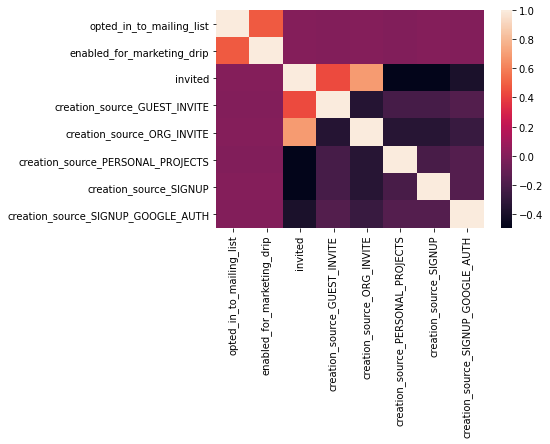

In [107]:
sns.heatmap(data.corr())

Heatmap shows that "creation_source:ORG_INVITE" (invited to an organization as full member), "enabled_for_marketing_drip" (whether they are on the regular marketing email drip), and "creation_source:GUEST_INVITE" (invited to an organization as a guest) seeems to have the higher correlations.

In [98]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier


In [99]:
# implementing train-test-split

X = data.drop('active', axis=1)
y = data['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [100]:
feature_importance = pd.Series(rfc.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)

creation_source_PERSONAL_PROJECTS     0.503426
creation_source_SIGNUP_GOOGLE_AUTH    0.167972
creation_source_SIGNUP                0.158135
invited                               0.076290
creation_source_GUEST_INVITE          0.041260
creation_source_ORG_INVITE            0.033034
enabled_for_marketing_drip            0.011335
opted_in_to_mailing_list              0.008547
dtype: float64


<AxesSubplot:>

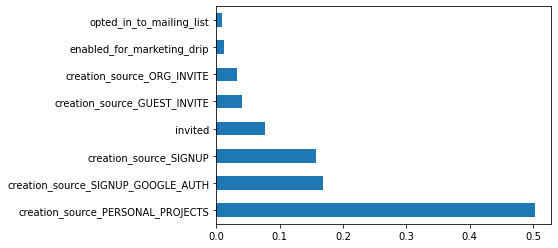

In [101]:
feature_importance.plot(kind = 'barh')

The feature importance scores are highest in the order of:\
    1. "creation_source: PERSONAL_PROJECTS"\
    2. "creation_source: SIGNUP_GOOGLE_AUTH"\
    3. "creation_source: SIGNUP"\
    4. "invited"\
    5. "creation _source: GUEST_INVITE"
    
How the user accounts were created/registered seem to play an import role in the user status.  Four out of five top importance are (user account) creation sources.  And whether they are invited by another user takes place in fourth place on the list.

    